In [10]:
import pandas as pd
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from random import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt


In [11]:
# Set the path to the dataset directory
DATASET_DIR = "C:/Users/Nurul Nadiah/OneDrive - Universiti Teknologi MARA/Desktop/FYP/cancer/dataset"

<h1>Pre Processing</h1>

In [12]:
# Preprocessing
def get_data(directory):
    X = []
    y = []
    classes = ['NORMAL', 'CANCER']

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        class_label = classes.index(class_name)

        for file in tqdm(os.listdir(class_dir)):
            if not file.startswith('.'):
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (150, 150))
                    X.append(img)
                    y.append(class_label)

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = get_data(os.path.join(DATASET_DIR, 'train'))


100%|██████████| 2483/2483 [00:47<00:00, 52.05it/s]


<h2>splitting training and testing data</h2>

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [15]:
# Convert labels to categorical
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

<h1>Working with CNN</h1>

In [16]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])


C:\Users\Nurul Nadiah\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
# Define callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')


<h1>Classification</h1>

In [18]:
# Train the model
batch_size = 32
epochs = 20

#classification
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_test, y_test), callbacks=[lr_reduce, checkpoint])


Epoch 1/20
125/125 [==============================] - 107s 837ms/step - loss: 0.6941 - accuracy: 0.5181 - val_loss: 0.6839 - val_accuracy: 0.6730 - lr: 1.0000e-04
Epoch 2/20
125/125 [==============================] - 93s 748ms/step - loss: 0.6497 - accuracy: 0.6407 - val_loss: 0.5534 - val_accuracy: 0.7867 - lr: 1.0000e-04
Epoch 3/20
125/125 [==============================] - 96s 768ms/step - loss: 0.4810 - accuracy: 0.7764 - val_loss: 0.3717 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 4/20
125/125 [==============================] - 95s 758ms/step - loss: 0.4045 - accuracy: 0.8303 - val_loss: 0.3294 - val_accuracy: 0.8541 - lr: 1.0000e-04
Epoch 5/20
125/125 [==============================] - 99s 794ms/step - loss: 0.3577 - accuracy: 0.8530 - val_loss: 0.2993 - val_accuracy: 0.8642 - lr: 1.0000e-04
Epoch 6/20
125/125 [==============================] - 87s 696ms/step - loss: 0.3319 - accuracy: 0.8620 - val_loss: 0.2832 - val_accuracy: 0.8712 - lr: 1.0000e-04
Epoch 7/20
125/125 [=======

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

32/32 [==============================] - 5s 166ms/step - loss: 0.0901 - accuracy: 0.9708
Test Loss: 0.09009073674678802
Test Accuracy: 0.9708249568939209


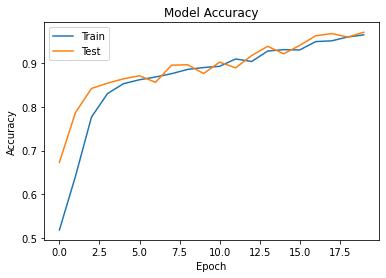

In [20]:
# Plot the accuracy and loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

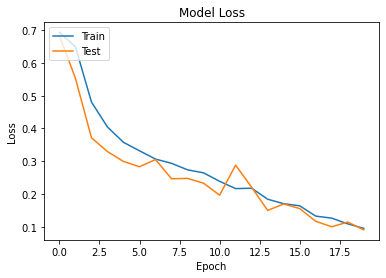

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<h1>Confusion Matrix</h1>

In [24]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

32/32 [==============================] - 5s 153ms/step


In [25]:
cnf = confusion_matrix(y_true, pred )
np.set_printoptions(precision=2)
cnf

array([[482,  20],
       [  9, 483]], dtype=int64)

In [26]:
from sklearn.metrics import accuracy_score
print ('Accuracy Score :',accuracy_score(y_true, pred)) 

Accuracy Score : 0.9708249496981891


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       502
           1       0.96      0.98      0.97       492

    accuracy                           0.97       994
   macro avg       0.97      0.97      0.97       994
weighted avg       0.97      0.97      0.97       994



In [28]:
from sklearn.metrics import precision_recall_curve

precision , recall , thresolds = precision_recall_curve(y_true, pred)

In [29]:
precision 

array([0.49, 0.96, 1.  ])

In [30]:
recall

array([1.  , 0.98, 0.  ])

In [31]:
thresolds

array([0, 1], dtype=int64)

In [33]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


32/32 [==============================] - 5s 145ms/step


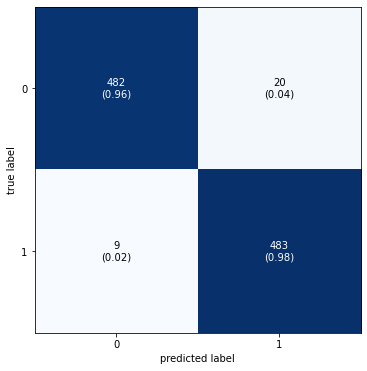

In [34]:
# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), show_absolute=True, show_normed=True)
plt.show()

<h1>Test prediction</h1>

In [35]:
from keras.models import load_model
from PIL import Image
import numpy as np

In [36]:
# Load the trained model
model = load_model('best_model.h5')

In [74]:
# Load and preprocess the test image
img_path = 'cancer/val/Cancer/_2_4392.jpeg'
img = Image.open(img_path)
img = img.resize((150, 150))
img = np.array(img) / 255.0
img = np.expand_dims(img, axis=0)


In [75]:
# Make predictions
probs = model.predict(img)
predicted_class = np.argmax(probs)

1/1 [==============================] - 0s 30ms/step


In [76]:
# Map the predicted class index to the class label
class_labels = ['NORMAL', 'CANCER']
predicted_label = class_labels[predicted_class]

# Display the predicted label
print("Predicted Label:", predicted_label)


Predicted Label: CANCER


In [77]:
# Load and preprocess the test image
img_path = 'cancer/val/Normal/_5_1558.jpeg'
img = Image.open(img_path)
img = img.resize((150, 150))
img = np.array(img) / 255.0
img = np.expand_dims(img, axis=0)

In [78]:
# Make predictions
probs = model.predict(img)
predicted_class = np.argmax(probs)

1/1 [==============================] - 0s 31ms/step


In [72]:
# Map the predicted class index to the class label
class_labels = ['NORMAL', 'CANCER']
predicted_label = class_labels[predicted_class]

# Display the predicted label
print("Predicted Label:", predicted_label)

Predicted Label: NORMAL
